# Hodoscope configuration: optimization

Let's try to run the optimisation

In [4]:
import torch
from torch import nn
from tomopt.volume import PassiveLayer

DEVICE = torch.device('cpu')

In [5]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from tomopt.volume import Volume

from tomopt.core import X0
from torch import Tensor

def get_simple_hod_config() -> Volume:

    init_xyz_span, xyz_gap = [1.5, 1.5, .3], [.1, .1, .1]
    init_eff, init_res = 0.90, 1e5

    hods = [Hodoscope(init_xyz= [0.25, 0.25, 1.2], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res, 
                      realistic_validation=False),
                      ]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([2,2]), 
                                                z = 1.3, size = 0.5, 
                                                hodoscopes = hods)

    hods = [Hodoscope(init_xyz= [.5, .5, 0.1], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res, 
                      realistic_validation=False
                     )]
    
    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([1,1]), 
                                                z = .2, size = 0.5, 
                                                hodoscopes = hods)

    def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)
    
    return Volume(get_layers([hod_detector_above, hod_detector_below]))

# Create the volume
volume = get_simple_hod_config()

from functools import partial
from tomopt.optimisation import VoxelX0Loss

from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

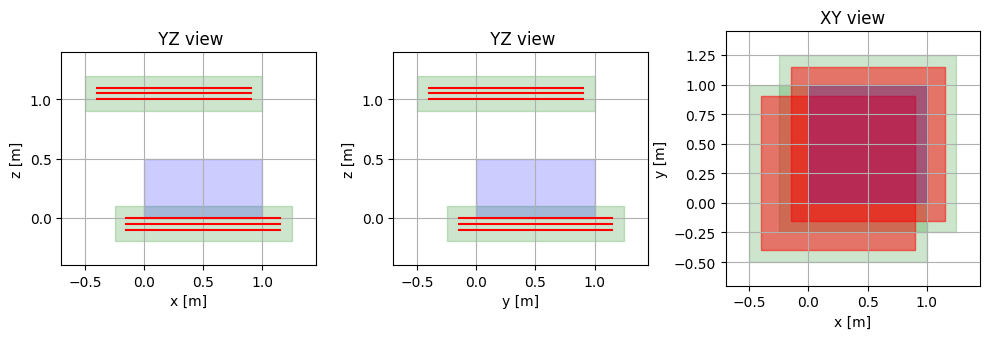

In [6]:
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume)

In [7]:
from tomopt.core import X0

def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['water']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

from tomopt.optimisation import PassiveYielder
passives = PassiveYielder([arb_rad_length,arb_rad_length], shuffle=True)

In [8]:
from tomopt.optimisation import NoMoreNaNs, CostCoefWarmup, OptConfig, MuonResampler
from callbacks.HodoscopeMetricLogger import HodoscopeMetricLogger
from callbacks.HodNoMoreNaNs import HodNoMoreNaNs

In [9]:
ml = HodoscopeMetricLogger()

In [10]:
passives = PassiveYielder([arb_rad_length])

In [11]:
det = volume.get_detectors()[0]
len(det.hodoscopes)

1

In [12]:
_ = wrapper.fit(n_epochs=20,  # Run for 10 epochs (5+5 are warmup epochs)
                passive_bs=1,  # Update every passive volumes (we only have one)
                n_mu_per_volume=5000,  # Use 1000 per passive volume
                mu_bs=100,  # Run the 1000 muons per volume in 10 batches of 100 muons (quicker than a single batch of 1000)
                trn_passives=passives,
                val_passives=passives,  # Evaluate on the training data
                cbs=[CostCoefWarmup(n_warmup=5), OptConfig(n_warmup=5, 
                                                           rates={'xy_pos_opt':0.01, 
                                                                  'z_pos_opt':0.005, 
                                                                  'xy_span_opt':0}), 
                                                                  MuonResampler(), 
                                                                  HodNoMoreNaNs(),
                                                                  ml])  # Use these three callbacks during training

2 warmup callbacks found, with a total warmup period of 10 epochs.
Automatically setting cost coefficient to 7.266676902770996


AttributeError: 'Hodoscope' object has no attribute 'clamp_params'

The panel metric logger is meant to be used with the `PanelDetectorLayer` class. Because we are using `HodoscopeDetectorLayer`, we must create a dedicated `HodoscopeMetricLogger` class.

In [ ]:
from __future__ import annotations

from typing import List, Tuple

import imageio
import matplotlib.lines as mlines
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
from fastprogress.fastprogress import IN_NOTEBOOK
from matplotlib.gridspec import GridSpec

import torch

from tomopt.volume import SigmoidDetectorPanel
from tomopt.optimisation.callbacks import Callback
from tomopt.optimisation.callbacks.monitors import MetricLogger


In [ ]:
class HodoscopeMetricLogger(MetricLogger):
    r"""
    Logger for use with :class:`~tomopt.volume.layer.HodoscopeDetectorLayer` s

    Arguments:
        gif_filename: optional savename for recording a gif of the optimisation process (None -> no gif)
            The savename will be appended to the callback savepath
        gif_length: If saving gifs, controls the total length in seconds
        show_plots: whether to provide live plots during optimisation in notebooks
    """

    def _reset(self) -> None:
        det = self.wrapper.volume.get_detectors()[0]
        if isinstance(det, HodoscopeDetectorLayer):
            panel = det.hodoscopes[0].panels[0]
            self.uses_sigmoid_panels = isinstance(panel, SigmoidDetectorPanel)
        else:
            self.uses_sigmoid_panels = False
        super()._reset()

    def _prep_plots(self) -> None:
        r"""
        Creates the plots for a new optimisation
        """

        super()._prep_plots()
        if self.show_plots:
            with sns.axes_style(**self.style):
                self.above_det = [self.fig.add_subplot(self.grid_spec[-2:-1, i : i + 1]) for i in range(3)]
                self.below_det = [self.fig.add_subplot(self.grid_spec[-1:, i : i + 1]) for i in range(3)]
                if self.uses_sigmoid_panels:
                    self.panel_smoothness = self.fig.add_subplot(self.grid_spec[-2:-1, -1:])
                self._set_axes_labels()

    def update_plot(self) -> None:
        r"""
        Updates the plot(s).
        """

        super().update_plot()
        with sns.axes_style(**self.style), sns.color_palette(self.cat_palette) as palette:
            for axes, det in zip([self.above_det, self.below_det], self.wrapper.get_detectors()):
                l, s = [], []
                if not isinstance(det, HodoscopeDetectorLayer):
                    raise ValueError(f"Detector {det} is not a HodoscopeDetectorLayer")
                for h in det.hodoscopes:
                    for p in h.panels:
                        if det.type_label == "heatmap":
                            l_val = np.concatenate((p.mu.detach().cpu().numpy().mean(axis=0), p.z.detach().cpu().numpy()))
                            s_val = p.sig.detach().cpu().numpy().mean(axis=0)
                            l.append(l_val)
                            s.append(s_val)
                        else:
                            l.append(np.concatenate((p.xy.detach().cpu().numpy(), p.z.detach().cpu().numpy())))
                            s.append(p.get_scaled_xy_span().detach().cpu().numpy())
                    loc, span = np.array(l), np.array(s)

                    for ax in axes:
                        ax.clear()

                    lw = self.wrapper.volume.lw.detach().cpu().numpy()
                    axes[2].add_patch(patches.Rectangle((0, 0), lw[0], lw[1], linewidth=1, edgecolor="black", facecolor="none", hatch="x"))  # volume

                    for p in range(len(loc)):
                        axes[0].add_line(
                            mlines.Line2D((loc[p, 0] - (span[p, 0] / 2), loc[p, 0] + (span[p, 0] / 2)), (loc[p, 2], loc[p, 2]), linewidth=2, color=palette[p])
                        )  # xz
                        axes[1].add_line(
                            mlines.Line2D((loc[p, 1] - (span[p, 1] / 2), loc[p, 1] + (span[p, 1] / 2)), (loc[p, 2], loc[p, 2]), linewidth=2, color=palette[p])
                        )  # yz
                        axes[2].add_patch(
                            patches.Rectangle(
                                (loc[p, 0] - (span[p, 0] / 2), loc[p, 1] - (span[p, 1] / 2)),
                                span[p, 0],
                                span[p, 1],
                                linewidth=1,
                                edgecolor=palette[p],
                                facecolor="none",
                            )
                        )  # xy

                    if self.uses_sigmoid_panels:
                        self.panel_smoothness.clear()
                        with torch.no_grad():
                            panel = det.panels[0]
                            width = panel.get_scaled_xy_span()[0].cpu().item()
                            centre = panel.xy[0].cpu().item()
                            x = torch.linspace(-width, width, 50)[:, None]
                            y = panel.sig_model(x + centre)[:, 0]
                            self.panel_smoothness.plot(2 * x.cpu().numpy() / width, y.cpu().numpy())

            self._set_axes_labels()

    def _build_grid_spec(self) -> GridSpec:
        r"""
        Returns:
            The layout object for the plots
        """

        self.n_dets = len(self.wrapper.get_detectors())
        return self.fig.add_gridspec(5 + (self.main_metric_idx is None), 3 + self.uses_sigmoid_panels)

    def _set_axes_labels(self) -> None:
        r"""
        Adds styling to plots after they are cleared
        """

        for ax, x in zip(self.below_det, ["x", "y", "x"]):
            ax.set_xlabel(x, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
        for i, (ax, x) in enumerate(zip(self.above_det, ["z", "z", "y"])):
            if i == 0:
                x = "Above, " + x
            ax.set_ylabel(x, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
        for i, (ax, x) in enumerate(zip(self.below_det, ["z", "z", "y"])):
            if i == 0:
                x = "Below, " + x
            ax.set_ylabel(x, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)

        for ax, det in zip((self.above_det, self.below_det), self.wrapper.get_detectors()):
            if not isinstance(det, HodoscopeDetectorLayer):
                raise ValueError(f"Detector {det} is not a HodoscopeDetectorLayer")
            lw, z = det.lw.detach().cpu(), det.z.detach().cpu()
            sizes = torch.stack([p.get_scaled_xy_span().detach().cpu() for h in det.hodoscopes for p in h.panels], dim=0) / 2
            poss = torch.stack([p.xy.detach().cpu() for h in det.hodoscopes for p in h.panels], dim=0)
            xy_min, xy_max = (poss - sizes).min(0).values, (poss + sizes).max(0).values
            margin = lw.max() / 2

            ax[0].set_xlim(min([1, xy_min[0].item()]) - (lw[0] / 2), max([lw[0].item(), xy_max[0].item()]) + (lw[0] / 2))
            ax[1].set_xlim(min([1, xy_min[1].item()]) - (lw[1] / 2), max([lw[1].item(), xy_max[1].item()]) + (lw[1] / 2))
            ax[2].set_xlim(xy_min.min() - margin, xy_max.max() + margin)
            ax[0].set_ylim(z - (1.25 * det.size), z + (0.25 * det.size))
            ax[1].set_ylim(z - (1.25 * det.size), z + (0.25 * det.size))
            ax[2].set_ylim(xy_min.min() - margin, xy_max.max() + margin)
            ax[2].set_aspect("equal", "box")

        if self.uses_sigmoid_panels:
            self.panel_smoothness.set_xlim((-2, 2))
            self.panel_smoothness.set_xlabel("Panel model (arb. pos.)", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)

2 warmup callbacks found, with a total warmup period of 10 epochs.


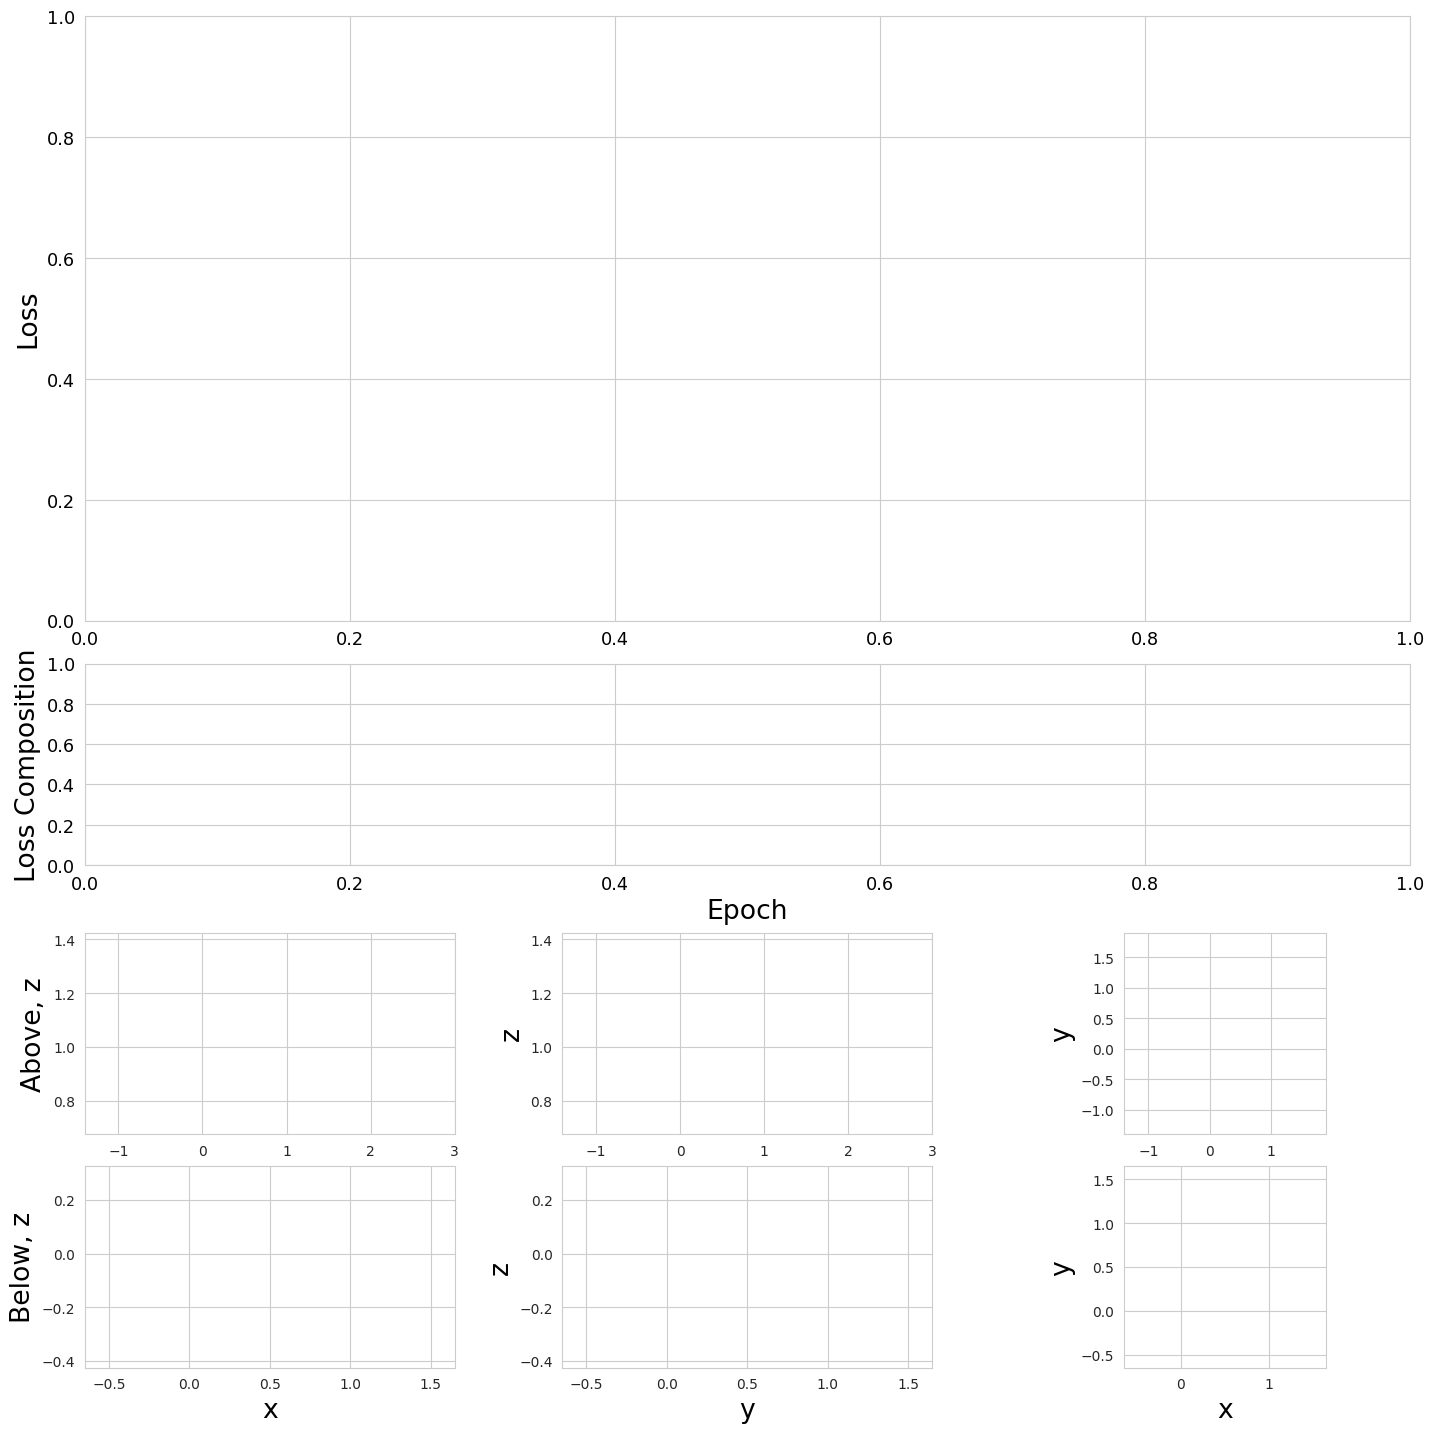

Automatically setting cost coefficient to 10.400489807128906
In OptConfig


NotImplementedError: NoMoreNaNs does not yet support <class 'volume.hodoscopelayer.HodoscopeDetectorLayer'>

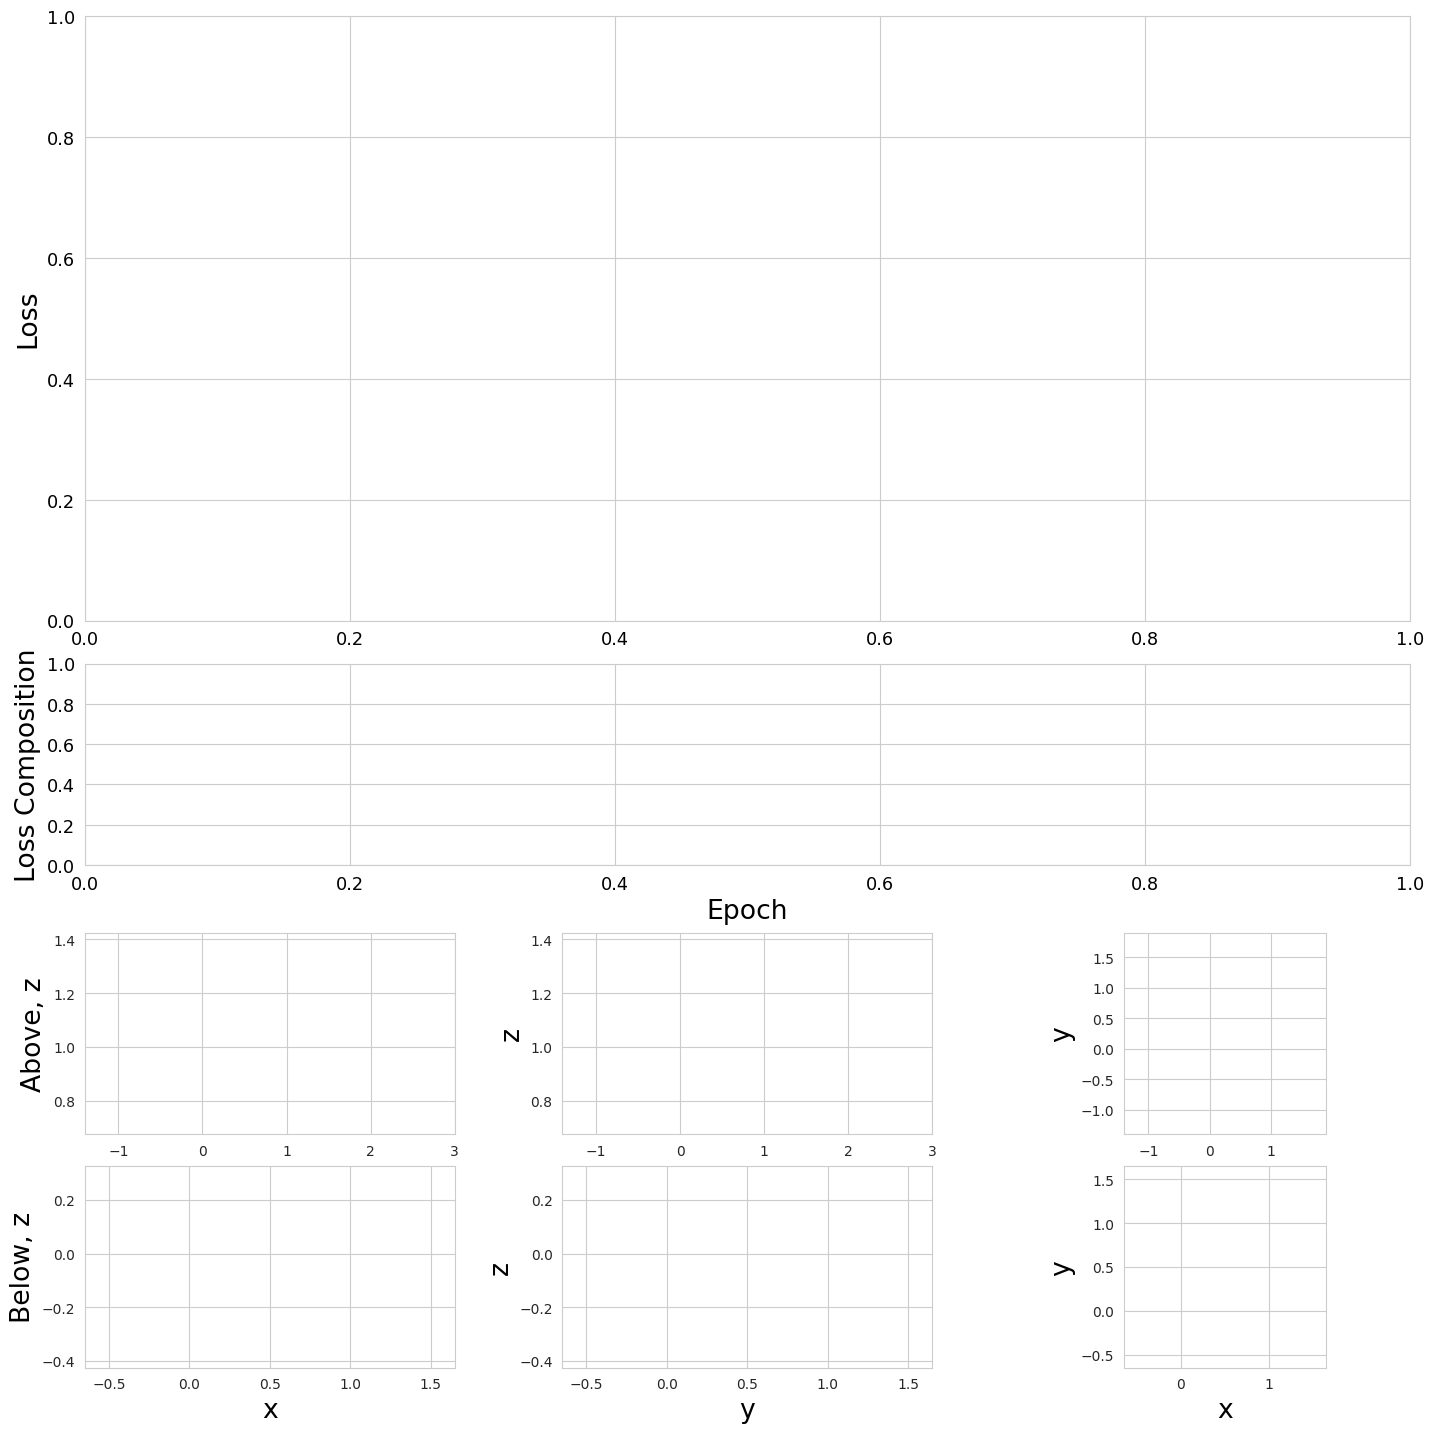

In [ ]:
ml = HodoscopeMetricLogger()

_ = wrapper.fit(n_epochs=20,  # Run for 10 epochs (5+5 are warmup epochs)
                passive_bs=1,  # Update every passive volumes (we only have one)
                n_mu_per_volume=5000,  # Use 1000 per passive volume
                mu_bs=100,  # Run the 1000 muons per volume in 10 batches of 100 muons (quicker than a single batch of 1000)
                trn_passives=passives,
                val_passives=passives,  # Evaluate on the training data
                cbs=[CostCoefWarmup(n_warmup=5), OptConfig(n_warmup=5, 
                                                           rates={'xy_pos_opt':0.01, 
                                                                  'z_pos_opt':0.005, 
                                                                  'xy_span_opt':0}), 
                                                                  MuonResampler(), 
                                                                  NoMoreNaNs(),
                                                                  ml])  # Use these three callbacks during training

The `NoMoreNans` has not been implemented yet for `HodoscopeDetectorLayer`. Let's fix this: 

In [ ]:
class NoMoreNaNsHodoscope(Callback):
    r"""
    Prior to parameter updates, this callback will check and set any NaN gradients to zero.
    Updates based on NaN gradients will set the parameter value to NaN.

    .. important::
        As new parameters are introduced, e.g. through new detector models, this callback will need to be updated.
    """

    def on_backwards_end(self) -> None:
        r"""
        Prior to optimiser updates, parameter gradients are checked for NaNs.
        """

        if hasattr(self.wrapper.volume, "budget_weights"):
            torch.nan_to_num_(self.wrapper.volume.budget_weights.grad, 0)
        for l in self.wrapper.volume.get_detectors():
            if isinstance(l, HodoscopeDetectorLayer):
                for h in l.hodoscopes:
                        for p in h.panels:
                            if l.type_label == "heatmap":
                                torch.nan_to_num_(p.mu.grad, 0)
                                torch.nan_to_num_(p.norm.grad, 0)
                                torch.nan_to_num_(p.sig.grad, 0)
                                torch.nan_to_num_(p.z.grad, 0)
                            else:
                                torch.nan_to_num_(p.xy.grad, 0)
                                torch.nan_to_num_(p.z.grad, 0)
                                torch.nan_to_num_(p.xy_span.grad, 0)
            else:
                raise NotImplementedError(f"NoMoreNaNs does not yet support {type(l)}")


2 warmup callbacks found, with a total warmup period of 10 epochs.


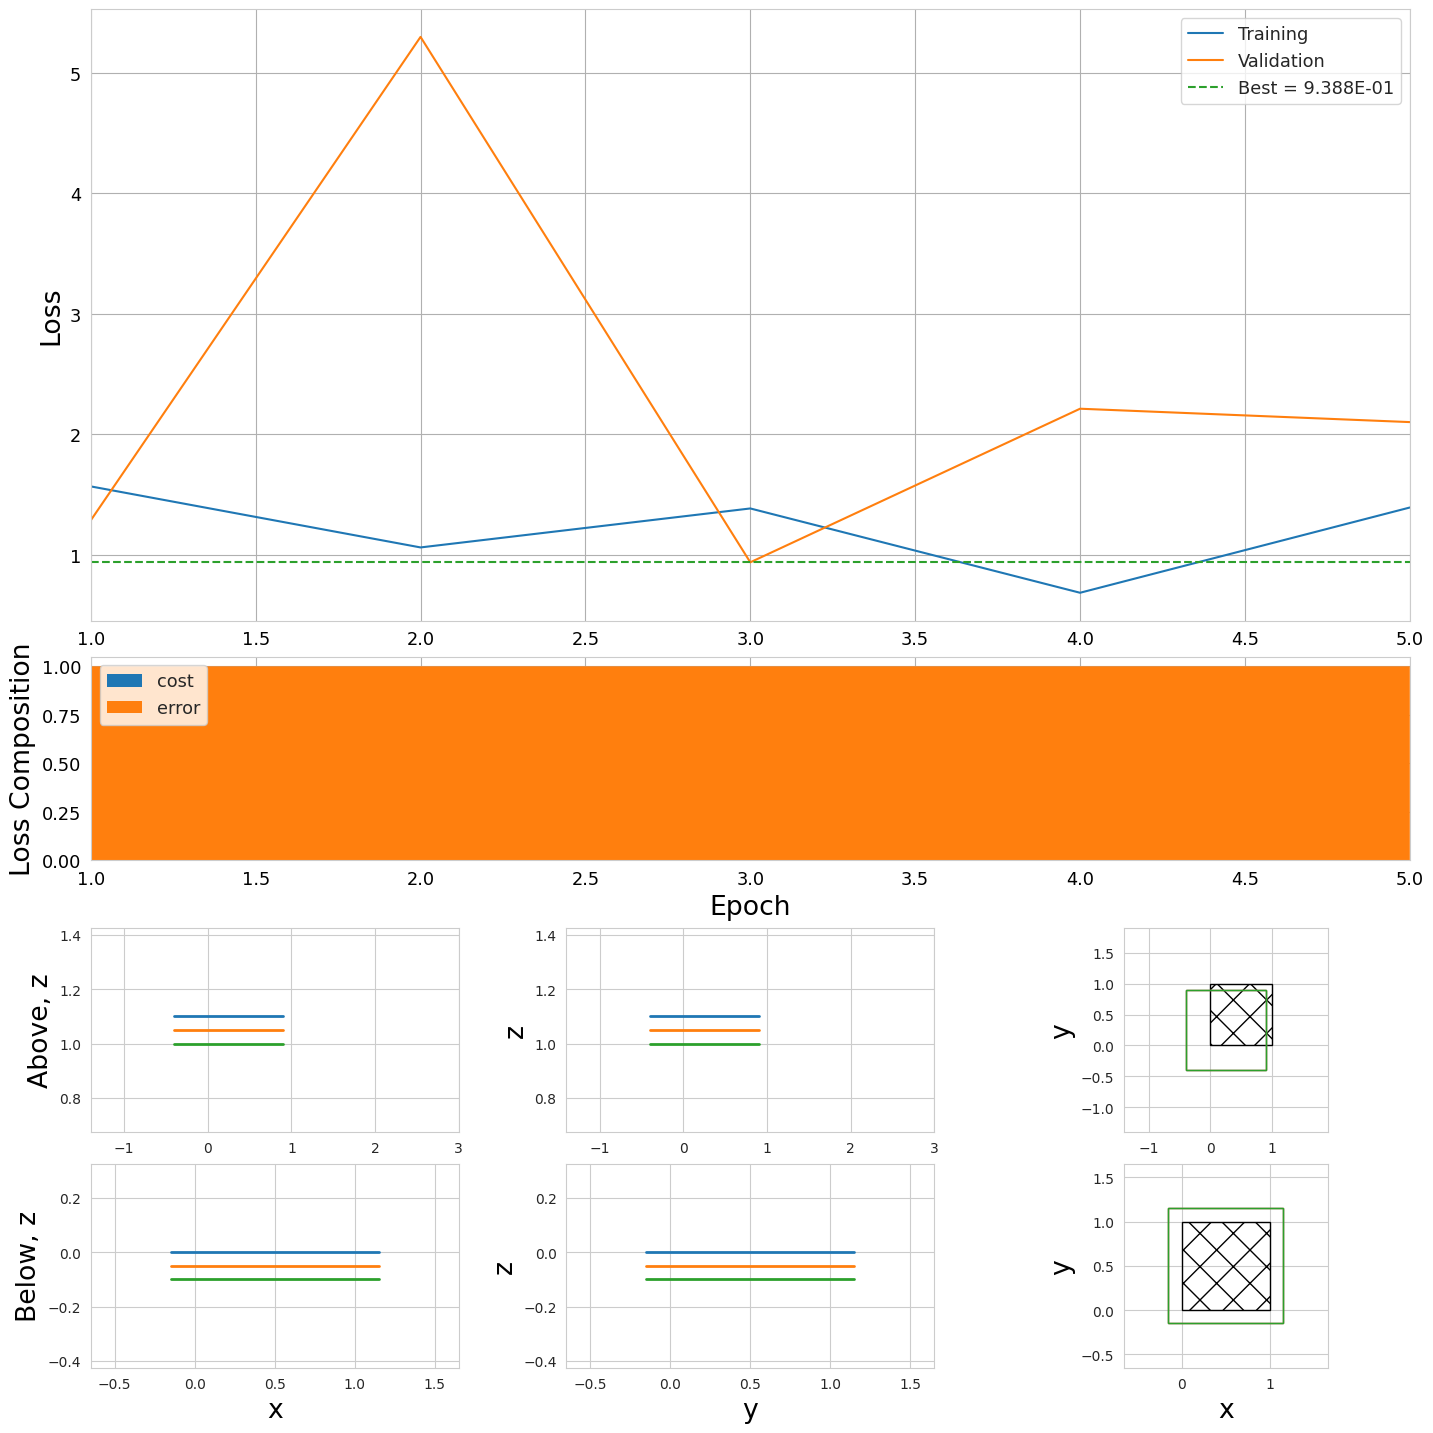

In OptConfig


/home/geant/Desktop/TASKS/TomOpt/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:219: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


In OptConfig
In OptConfig
In OptConfig
In OptConfig
CostCoefWarmup: Warmed up, average error = 1.3847895860671997
In OptConfig
rates =  {'xy_pos_opt': 0.01, 'z_pos_opt': 0.005, 'xy_span_opt': 0}
opt =  xy_pos_opt
params =  [Parameter containing:
tensor([0.2500, 0.2500], requires_grad=True), Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)]
param =  Parameter containing:
tensor([0.2500, 0.2500], requires_grad=True)
is leaf  True
requires_grad  True


AttributeError: 'NoneType' object has no attribute 'abs'

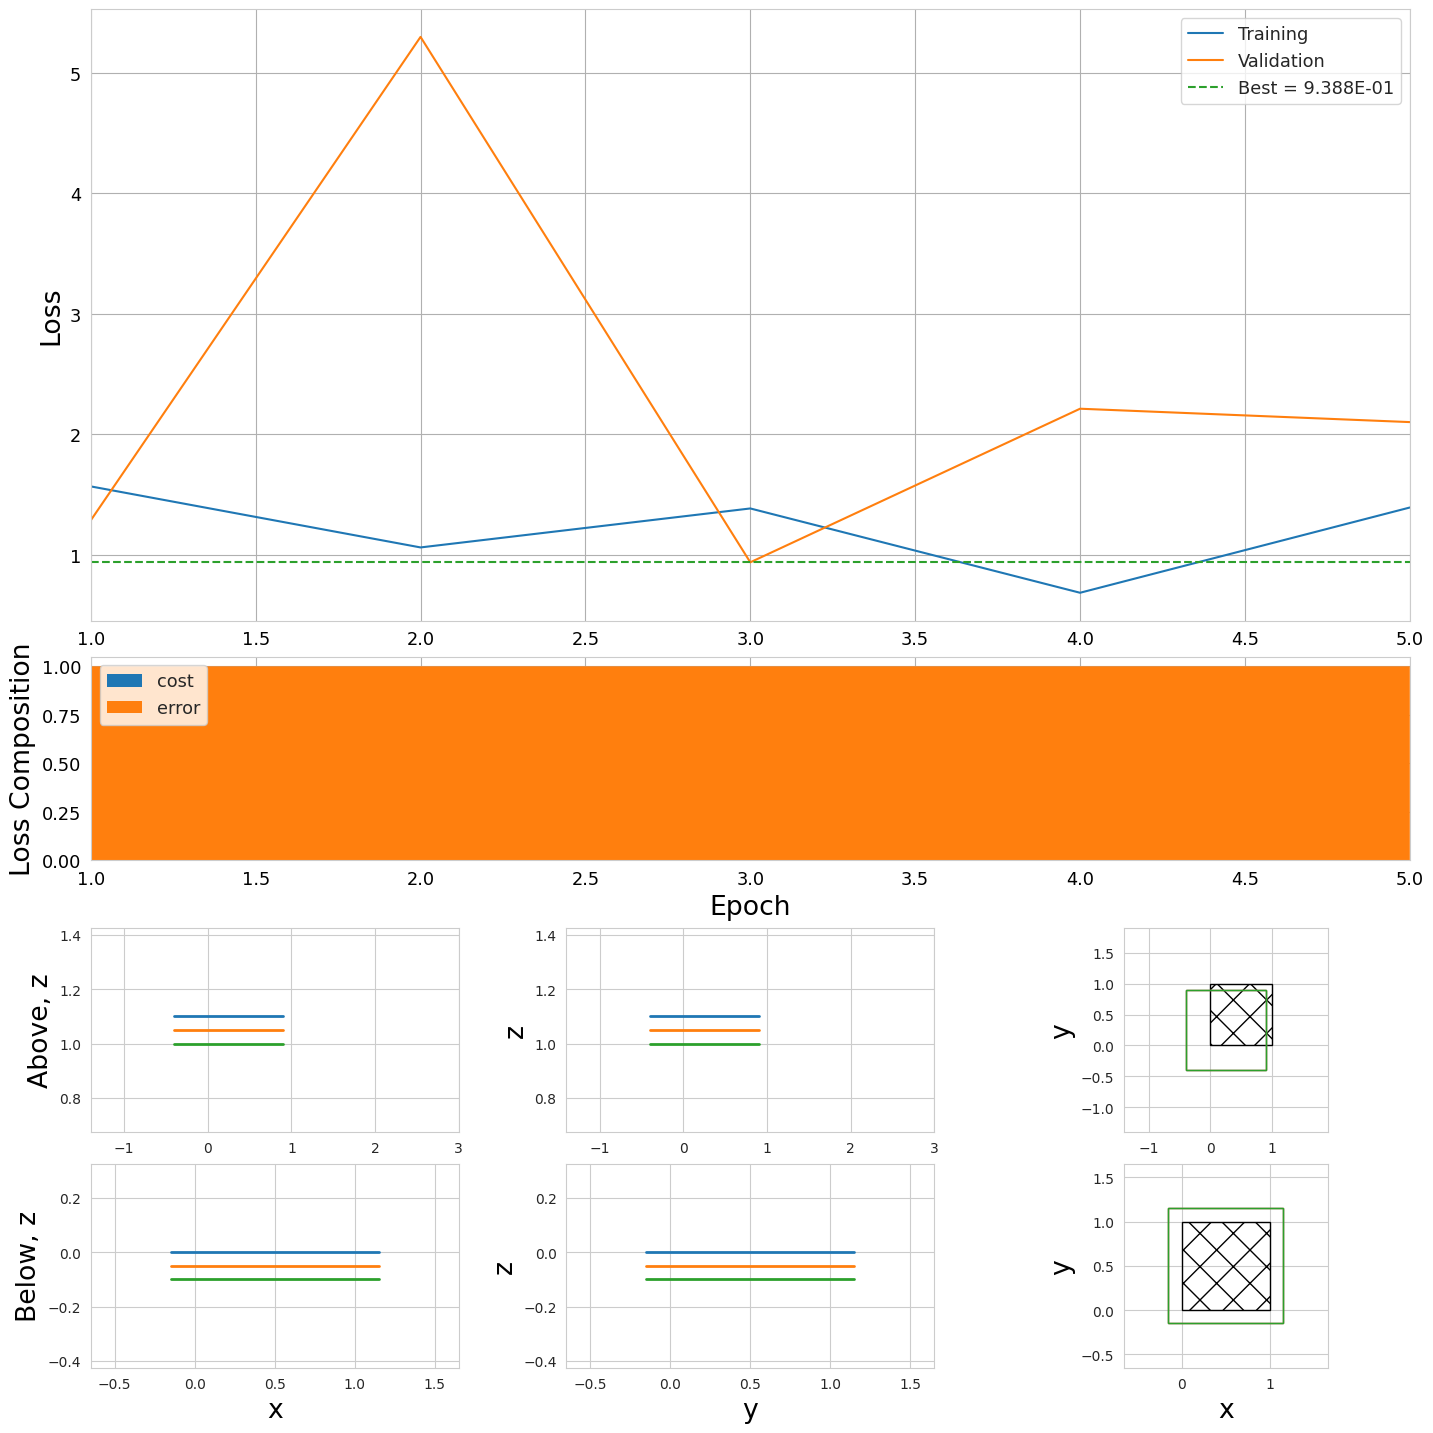

In [ ]:
ml = HodoscopeMetricLogger()

_ = wrapper.fit(n_epochs=20,  # Run for 10 epochs (5+5 are warmup epochs)
                passive_bs=1,  # Update every passive volumes (we only have one)
                n_mu_per_volume=5000,  # Use 1000 per passive volume
                mu_bs=100,  # Run the 1000 muons per volume in 10 batches of 100 muons (quicker than a single batch of 1000)
                trn_passives=passives,
                val_passives=passives,  # Evaluate on the training data
                cbs=[CostCoefWarmup(n_warmup=5), OptConfig(n_warmup=5, 
                                                           rates={'xy_pos_opt':0.01, 
                                                                  'z_pos_opt':0.005, 
                                                                  'xy_span_opt':0}), 
                                                                  MuonResampler(), 
                                                                  NoMoreNaNsHodoscope(),
                                                                  ml])  # Use these three callbacks during training